## Exam Text Mining 2023

### Import libraries 

In [70]:
import re
import json
import time
import gensim
import numpy as np
import pandas as pd
import spacy as spacy
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel
from gensim.models import CoherenceModel
from collections import Counter
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.sparse import csr_matrix

### Load csv file

In [71]:
#Loading the csv-file with pandas and printing the first 5 rows

f = 'own_path\csv'
df = pd.read_csv(f, skiprows=[0, 0], delimiter= ';', usecols=['genres', 'keywords', 'original_title', 'overview', 'tagline'])
print(df.head())

                                              genres  \
0  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                            keywords  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...   
2  [{"id": 470, "name": "spy"}, {"id": 818, "name...   
3  [{"id": 849, "name": "dc comics"}, {"id": 853,...   
4  [{"id": 818, "name": "based on novel"}, {"id":...   

                             original_title  \
0                                    Avatar   
1  Pirates of the Caribbean: At World's End   
2                                   Spectre   
3                     The Dark Knight Rises   
4                               John Carter   

                                           

#### Clean the columns in the dataset

In [72]:
#Create a new empty list 
genres_new = []

#For value in column 'genres', load the string and extract value associated with "name". Append this to the list
for val in df['genres']:
        json_str = val
        genres = json.loads(json_str)
        genres_names = [genre.get("name") for genre in genres]
        genres_new.append(genres_names)

#Create a new df-column and give it values from the new list. Delete the column 'genres'
df['genres_clean'] = genres_new
df.drop(columns = ['genres'], inplace=True)

#Create new empty list
keywords_new = []

#For value in column 'keywords'. If value is null, set 'keywords_names to an empty list. 
#Else parse string and extract key associated with "name". Appends keywords_names to keywords_new

for val in df['keywords']:
    if pd.isna(val):
        keywords_names = []
    else:
        json_str = val
        keywords = json.loads(json_str)
        keywords_names = [keyword.get("name") for keyword in keywords]
    keywords_new.append(keywords_names)

#Create a new df-column and give it values from the new list. Delete the column 'keywords'
df['keywords_clean'] = keywords_new
df.drop(columns = ['keywords'], inplace=True)

print('After cleaning columns: ', '\n', df[['genres_clean', 'keywords_clean']].head())

After cleaning columns:  
                                     genres_clean  \
0  [Action, Adventure, Fantasy, Science Fiction]   
1                   [Adventure, Fantasy, Action]   
2                     [Action, Adventure, Crime]   
3               [Action, Crime, Drama, Thriller]   
4           [Action, Adventure, Science Fiction]   

                                      keywords_clean  
0  [culture clash, future, space war, space colon...  
1  [ocean, drug abuse, exotic island, east india ...  
2  [spy, based on novel, secret agent, sequel, mi...  
3  [dc comics, crime fighter, terrorist, secret i...  
4  [based on novel, mars, medallion, space travel...  


### Preprosessing

In [73]:
#Transform dataframe to a list
raw_data = df.values.tolist()

#Load "en_core_web_sm" with parser and ner disabled.
nlp = spacy.load("en_core_web_sm", disable = ['parser', 'ner'])

#Function for preprocessing. Strips and puts everything to lowercase, removes punctation and creates tokens for each row
def preprocessing(data):
    out = []
    if type(data) == list:
        for lst in data:
            tokens = []
            for item in lst:
                if type(item) == str:
                    words = item.split()
                    tokens.extend([''.join(c.strip().lower() for c in w if c.isalnum()) for w in words])
                elif type(item) == list:
                    joined_str = ' '.join(str(x) for x in item)
                    words = joined_str.split()
                    tokens.extend([''.join(c.strip().lower() for c in w if c.isalnum()) for w in words])
            out.append(tokens)
    elif type(data) == str:
        words = data.split()
        out.extend([''.join(c.strip().lower() for c in w if c.isalnum()) for w in words])
    return out

#Calls the function on the raw_data and prints the first three elements from the preprocessed list
preprocessed_list = preprocessing(raw_data)
print(preprocessed_list[:3])

[['avatar', 'in', 'the', '22nd', 'century', 'a', 'paraplegic', 'marine', 'is', 'dispatched', 'to', 'the', 'moon', 'pandora', 'on', 'a', 'unique', 'mission', 'but', 'becomes', 'torn', 'between', 'following', 'orders', 'and', 'protecting', 'an', 'alien', 'civilization', 'enter', 'the', 'world', 'of', 'pandora', 'action', 'adventure', 'fantasy', 'science', 'fiction', 'culture', 'clash', 'future', 'space', 'war', 'space', 'colony', 'society', 'space', 'travel', 'futuristic', 'romance', 'space', 'alien', 'tribe', 'alien', 'planet', 'cgi', 'marine', 'soldier', 'battle', 'love', 'affair', 'anti', 'war', 'power', 'relations', 'mind', 'and', 'soul', '3d'], ['pirates', 'of', 'the', 'caribbean', 'at', 'worlds', 'end', 'captain', 'barbossa', 'long', 'believed', 'to', 'be', 'dead', 'has', 'come', 'back', 'to', 'life', 'and', 'is', 'headed', 'to', 'the', 'edge', 'of', 'the', 'earth', 'with', 'will', 'turner', 'and', 'elizabeth', 'swann', 'but', 'nothing', 'is', 'quite', 'as', 'it', 'seems', 'at', 't

#### Lemmatizing

In [74]:
#Apply spaCy to preprocessed_list
doc_list = [nlp(' '.join(tokens)) for tokens in preprocessed_list]

#Lemmatize each token. Remove stopwords, words containing numbers, unwanted characters, words with len <= 2 and words with only the same characters (like 'aaa')
unwanted_characters = ['γη', 'κυνόδοντας', 'белка', 'богом', 'быть', 'возвращение', 'воина', 'географ', 'глобус', 'дозор', 'звёздные', 'и', 'королева', 'монгол', 'ночной', 'пропил', 'савва', 'сердце', 'снежная', 'собаки', 'солярис', 'стрелка', 'трудно', 'آسمان', 'از', 'بنات', 'بچههای', 'جدایی', 'دایره', 'سكر', 'سیمین', 'نادر', 'अलवद', 'एबसड', 'कभ', 'कष', 'कह', 'कहन', 'ज', 'दल', 'न', 'भ', 'ரமனஜன', 'வல', 'ตมยำกง', 'สรโยไท', 'まあだだよ', 'もののけ姫', 'アキラ', 'キャプテンハーロック', 'キュア', 'シンゴジラ', 'ハウルの動く城', '一代宗師', '一個人的武林', '一個好人', '七人の侍', '三国之见龙卸甲', '三城记', '三枪拍案惊奇', '兔侠传奇', '刺客聶隱娘', '剑雨', '功夫', '十月圍城', '十面埋伏', '千と千尋の神隠し', '南京南京', '卧底肥妈', '卧虎藏龙', '天將雄師', '少林足球', '崖の上のポニョ', '归来', '投名狀', '放逐', '新宿事件', '最后的舞者', '滿城盡帶黃金甲', '疯狂的石头', '疯狂的赛车', '紅番區', '绝地奶霸', '英雄', '葉問3', '西游记之孙悟空三打白骨精', '超级妈妈', '辛亥革命', '逃出生天', '醉拳二', '金陵十三釵', '長江七號', '非常幸运', '風暴', '黃石的孩子', 'émigré', 'évolution', 'í', 'única', 'übertarget', 'și', '곡성', '괴물', '금자씨', '나쁜', '놈', '디워', '실미도', '올드보이', '이상한', '인천상륙작전', '좋은', '친절한', '태극기', '해운대', '휘날리며']
lemmatized_list = [[token.lemma_.strip().lower() for token in doc if not token.is_stop and token.is_alpha and token.lemma_.strip().lower() not in unwanted_characters and len(token.lemma_) > 2 and not re.match(r'^(\w)\1{2,}$', token.text)] for doc in doc_list] 

#Create corpus and printing first three elements
corpus = [' '.join(tokens) for tokens in lemmatized_list]
print(corpus[:3])



['avatar century paraplegic marine dispatch moon pandora unique mission tear follow order protect alien civilization enter world pandora action adventure fantasy science fiction culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relation mind soul', 'pirate caribbean world end captain barbossa long believe dead come life head edge earth turner elizabeth swann end world adventure begin adventure fantasy action ocean drug abuse exotic island east india trading company love one life traitor shipwreck strong woman ship alliance calypso afterlife fighter pirate swashbuckler aftercreditsstinger', 'spectre cryptic message bond past send trail uncover sinister organization battle political force secret service alive bond peel layer deceit reveal terrible truth spectre plan escape action adventure crime spy base novel secret agent sequel british secret service united kingdom']


### Making vocabulary

In [75]:
#Creating vocabulary 
all_tokens = []
for tokens in lemmatized_list:
    all_tokens.extend(tokens)

vocabulary = sorted(set(all_tokens))

#Printing first thirty elements in vocabulary and the total length
print(vocabulary[:30], '\n')
print('The length of the vocabulary: ', len(vocabulary))

['aame', 'aang', 'aaron', 'aba', 'abaddon', 'abagnale', 'abandon', 'abandonment', 'abba', 'abbas', 'abbate', 'abberline', 'abbey', 'abbie', 'abbott', 'abby', 'abdicate', 'abdication', 'abduct', 'abduction', 'abductor', 'abe', 'abel', 'aberdeen', 'abernathy', 'abhor', 'abhorrent', 'abide', 'abigail', 'ability'] 

The length of the vocabulary:  21700


### Feature extraction
#### Bag of Words

In [76]:
#Creating a CountVectorizer from sklearn
count_vectorizer = CountVectorizer()

#Using fit_transform(). Returns a document term-matrix of word-counts
bow = count_vectorizer.fit_transform(corpus)

#Printing bag og words as a 2D-array and the shape. 
print(bow.toarray())
print('\nThe shape of the array: ', bow.toarray().shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

The shape of the array:  (4804, 21700)


#### TF-IDF

In [77]:
#Creating a TfidfVectorizer from sklearn
tfidf_vectorizer = TfidfVectorizer(min_df=1)

#Using fit_transform. Rerturns document term-matrix of TF-IDF weights
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

#Printing tfidf as 2D-array and the shape.
print(tfidf_matrix.toarray())
print('\nThe shape of the array: ', tfidf_matrix.toarray().shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

The shape of the array:  (4804, 21700)


#### Find three most similar rows with only TF-IDF
##### To illustrate that the algorithm works properly 

In [78]:
#Calculate cosine similarity
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

#Get the row index for the row you want as sample
row_idx = 0

#Get the cosine similarities for sample-row
row_similarities = cosine_similarities[row_idx]

#Get top three most similar rows
most_similar_indices = row_similarities.argsort()[:-5:-1][1:]

#Printing top three most similar rows to sample
i=0
print('| Sample: \t|',row_idx,'\t|',df.loc[row_idx,'tagline'],'\t|',df.loc[row_idx,'original_title'] )
for item in most_similar_indices:
    i+=1
    print('| Match',i,'\t|',item,'\t|',df.loc[item,'tagline'],'\t|',df.loc[item,'original_title'])


| Sample: 	| 0 	| Enter the World of Pandora. 	| Avatar
| Match 1 	| 2404 	| This Time It's War 	| Aliens
| Match 2 	| 374 	| Let There Be Life. 	| Mission to Mars
| Match 3 	| 3159 	| In space no one can hear you scream. 	| Alien


### Topic modelling
#### Coherence score
##### LSA TF-IDF


In [79]:
#Setting random seed to 42
np.random.seed(42) 

#Creates a dictionary from lemmatized_list
id2word = corpora.Dictionary(lemmatized_list)

#Create a TfidfModel from gensim and create corpus
tfidf_model = TfidfModel([id2word.doc2bow(text) for text in lemmatized_list])
tfidf_corpus = tfidf_model[[id2word.doc2bow(text) for text in lemmatized_list]]

#Create LsiModel and CoherenceModel from gensim library, and get coherence-score
lsi_model = LsiModel(tfidf_corpus, num_topics=4, id2word=id2word)
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=lemmatized_list, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()

#Printing the coherence score with four decimals
print('Coherence score for LSA TF-IDF: ', coherence_lsi.round(4))

Coherence score for LSA TF-IDF:  0.4538


##### LSA BoW

In [80]:
#Setting random seed to 42
np.random.seed(42)  

#Sets corpus to lemmatized_list
texts = lemmatized_list
bow_corpus = [id2word.doc2bow(text) for text in texts]

#Create LsiModel and CoherenceModel from gensim, and get coherence-score
lsi_model = LsiModel(bow_corpus, num_topics=4, id2word=id2word)
coherence_model_lsi = CoherenceModel(model=lsi_model, texts=lemmatized_list, dictionary=id2word, coherence='c_v')
coherence_lsi = coherence_model_lsi.get_coherence()

#Printing the coherence score with four decimals
print('Coherence score for LSA BoW: ', coherence_lsi.round(4))

Coherence score for LSA BoW:  0.4353


##### LDA TF-IDF

In [81]:
#Creates LdaModel from gensim
lda_model = LdaModel(tfidf_corpus, 
                     num_topics=4, 
                     id2word=id2word, 
                     random_state=42, 
                     update_every=1, 
                     chunksize=100, 
                     passes=10, 
                     alpha='auto', 
                     per_word_topics=True)

#Creates CoherenceModel from gensim library, and gets the coherence-score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

#Printing the coherence score with four decimals
print('Coherence score for LDA TF-IDF: ', coherence_lda.round(4))

Coherence score for LDA TF-IDF:  0.3558


##### LDA BoW

In [82]:
#Creates LdaModel from gensim
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


#Creates CoherenceModel from gensim library, and gets the coherence-score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

#Printing the coherence score with four decimals
print('Coherence score LDA BoW: ', coherence_lda.round(4))

Coherence score LDA BoW:  0.3812


#### LSA TF-IDF with four topics

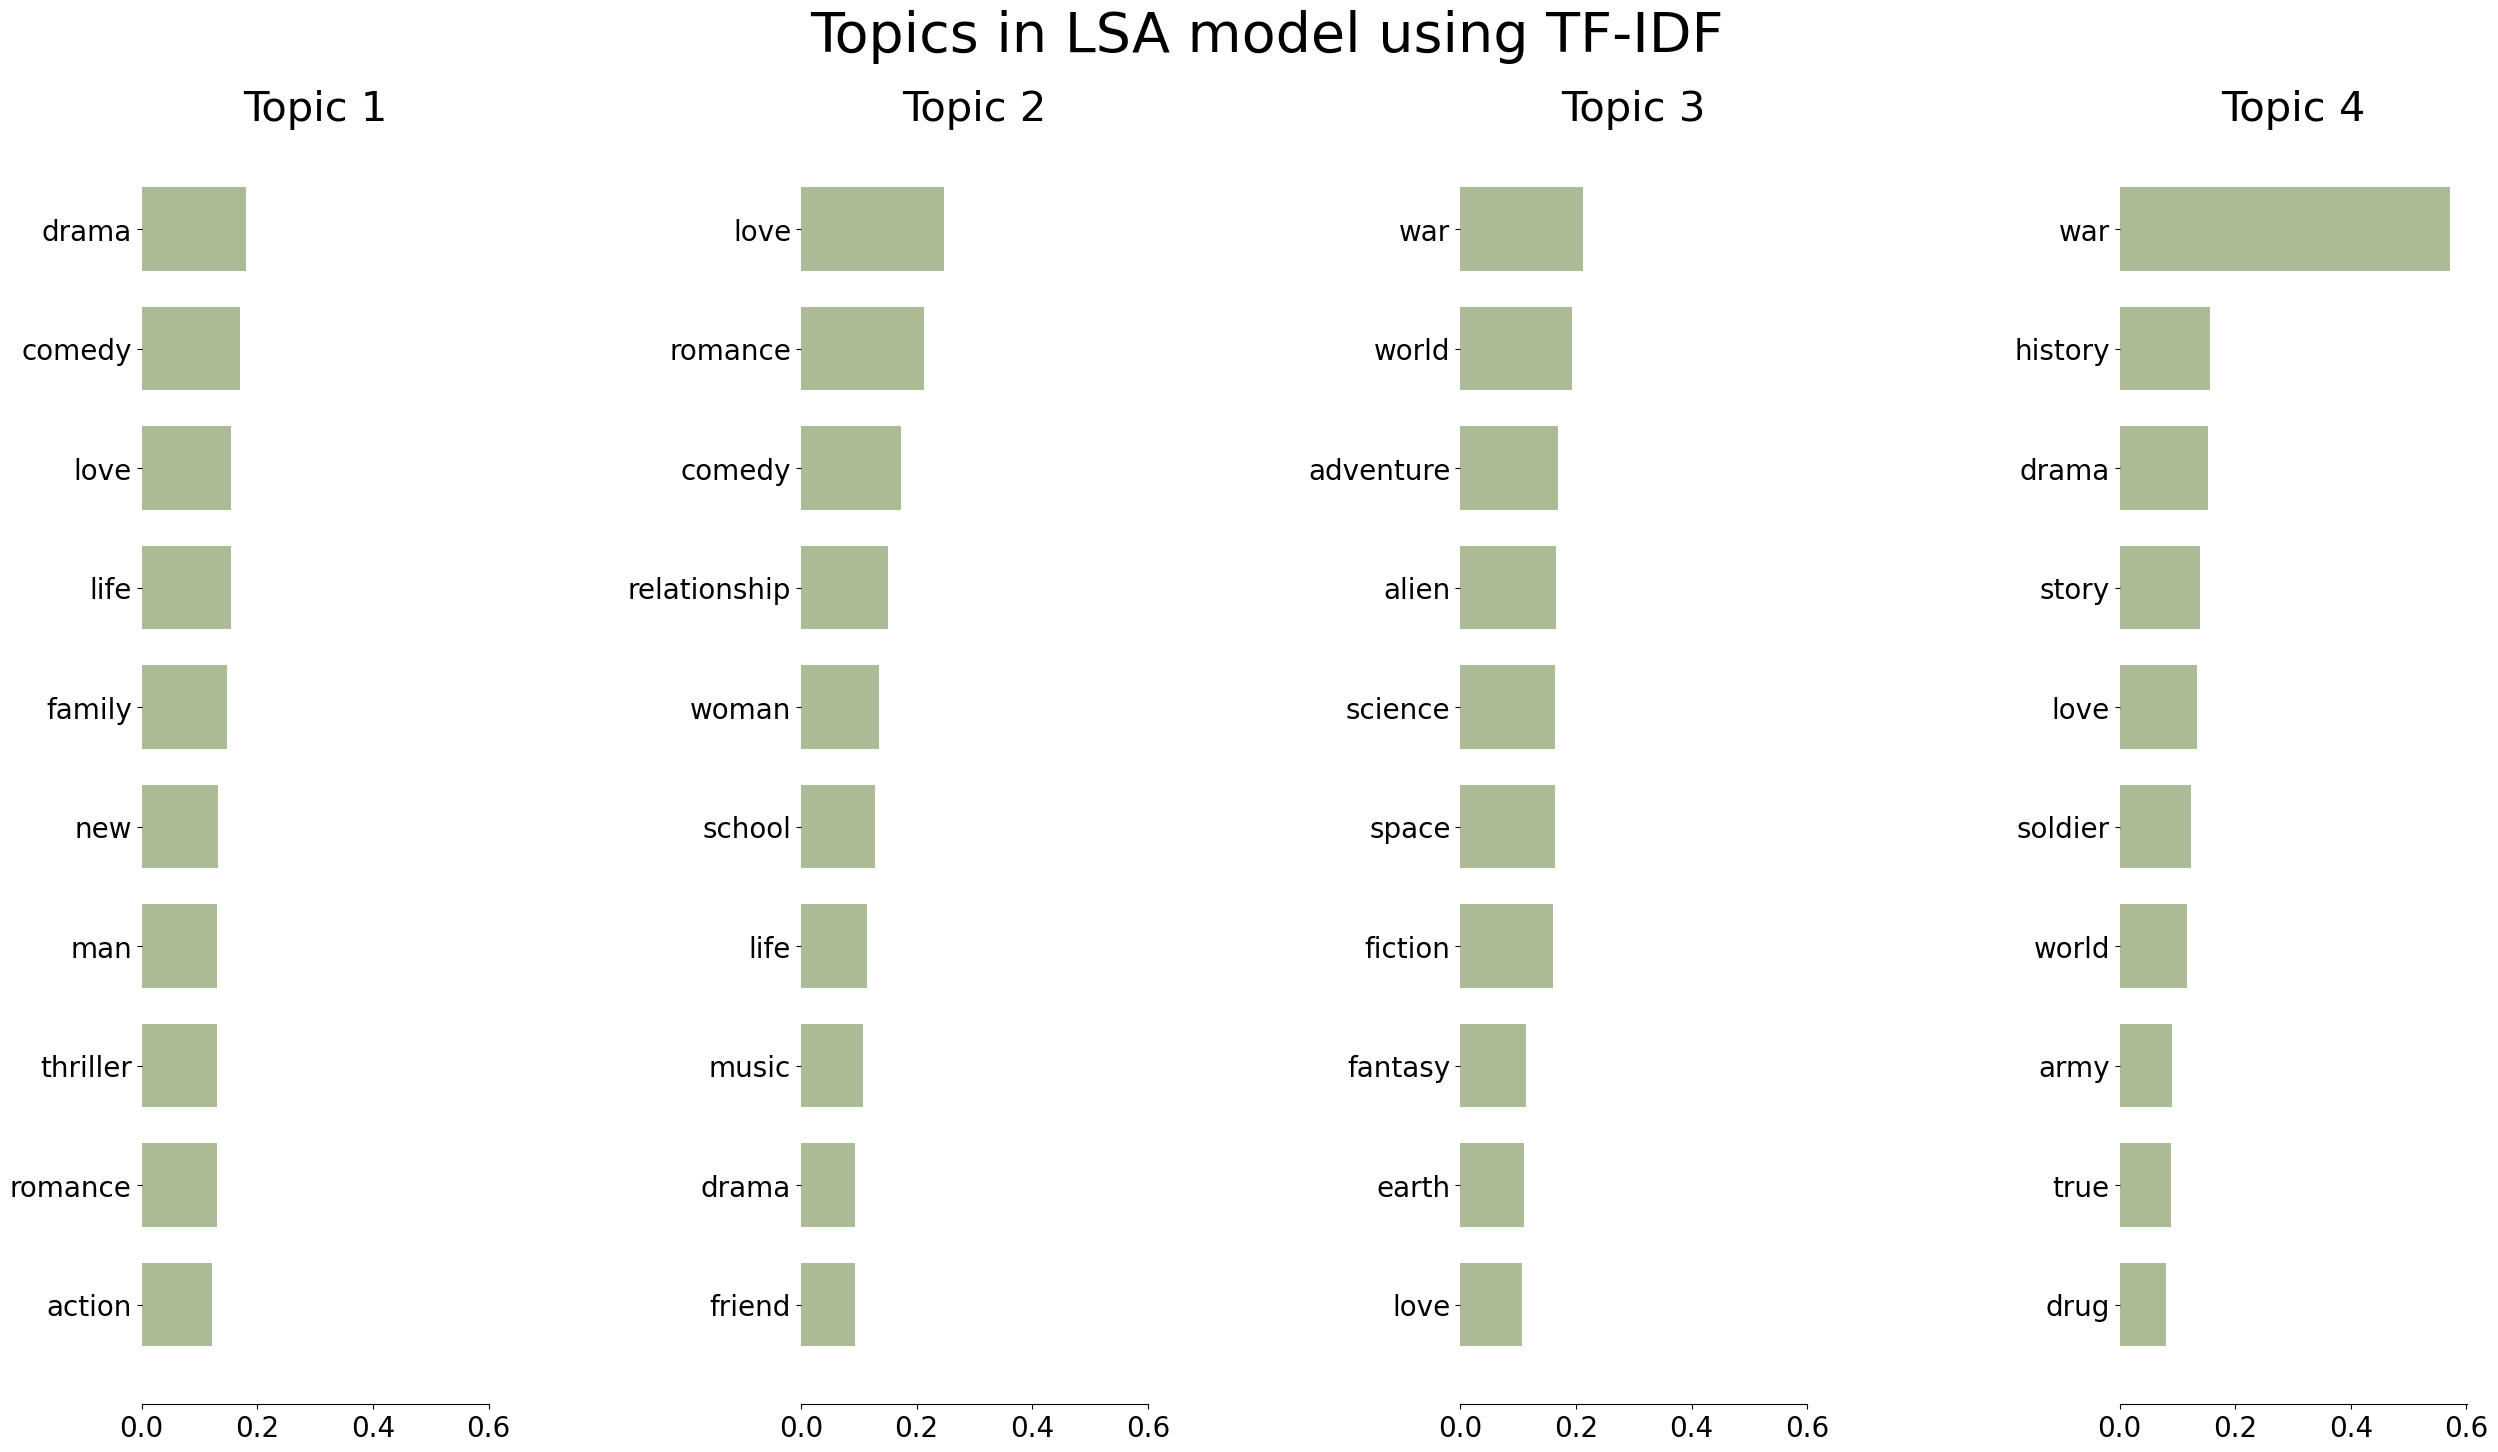

In [83]:
#Creates TruncatedSVD from sklearn
svd = TruncatedSVD(n_components=4, n_iter=100)

#Perform dimensionality reduction on tfidf_matrix. Returns reduced dense array of tfidf_matrix
svd_topic_tfidf = svd.fit_transform(tfidf_matrix.toarray())
svd_topic_tfidf = pd.DataFrame(svd_topic_tfidf)


#Function that plots top feature names for each topic
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color= '#aabb96')
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

#Get feature names from TfidfVectorizer
get_feature_names = tfidf_vectorizer.get_feature_names_out()

#Plot top words for LSA topics
plot_top_words(svd, get_feature_names, 10, "Topics in LSA model using TF-IDF")

#### K-Means
##### Finding Elbow-point

Text(0.5, 1.0, 'Finding optimal number of clusters')

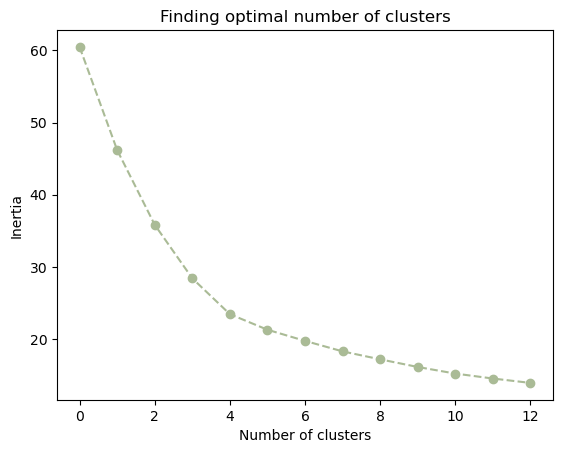

In [84]:
#Creates empty list
inertia = []

#Set range of K
K = range(1,14)

#For each value in K, create KMeans with k clusters, fit reduced tfidf_matrix, append inertia-value
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(svd_topic_tfidf) 
    inertia.append(kmeanModel.inertia_)
    
#Plot graph
plt.plot(inertia, marker='o', linestyle='--', color='#aabb96')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Finding optimal number of clusters')

##### K-means with TF-IDF

In [85]:
#Setting number of clusters to three
n_clusters = 3

#Creates KMeans from sklearn and and compute k-means for tdidf_matrix
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=1, random_state=42)
kmeans.fit(tfidf_matrix)

#Creates a new column with cluster labels
cluster_labels = kmeans.labels_
df['cluster_labels'] = cluster_labels

#Printing number of documents for each cluster
print('Distribution of documents:')
print(Counter(kmeans.labels_))

Distribution of documents:
Counter({1: 2264, 2: 1426, 0: 1114})


### Query
#### Preprocess

In [86]:
#Create a query and preprocess this query
query = "Avatar: The Way of Water. Jake Sully lives with his newfound family formed on the extrasolar moon Pandora. Once a familiar threat returns to finish what was previously started, Jake must work with Neytiri and the army of the Na'vi race to protect their home. Adventure, Action, Fantasy"
preprocessing_query = preprocessing(query)

#Printing preprocessed query
print('Preprocessed query: ', preprocessing_query, '\n')

#Lemmatizing the query
query_list = nlp(' '.join(preprocessing_query))
lemmatized_query_list = [token.lemma_.strip().lower() for token in query_list if not token.is_stop and token.is_alpha and token.lemma_.strip().lower() and len(token.lemma_) > 2 and not re.match(r'^(\w)\1{2,}$', token.text)]

#Printing out lemmatized query
print('Lemmatized query: ', lemmatized_query_list, '\n')

#Creating a corpus for the query and printing this corpus
query_corpus = [' '.join(lemmatized_query_list)]
print('Corpus for query: ', query_corpus)

Preprocessed query:  ['avatar', 'the', 'way', 'of', 'water', 'jake', 'sully', 'lives', 'with', 'his', 'newfound', 'family', 'formed', 'on', 'the', 'extrasolar', 'moon', 'pandora', 'once', 'a', 'familiar', 'threat', 'returns', 'to', 'finish', 'what', 'was', 'previously', 'started', 'jake', 'must', 'work', 'with', 'neytiri', 'and', 'the', 'army', 'of', 'the', 'navi', 'race', 'to', 'protect', 'their', 'home', 'adventure', 'action', 'fantasy'] 

Lemmatized query:  ['avatar', 'way', 'water', 'jake', 'sully', 'live', 'newfound', 'family', 'form', 'extrasolar', 'moon', 'pandora', 'familiar', 'threat', 'return', 'finish', 'previously', 'start', 'jake', 'work', 'neytiri', 'army', 'navi', 'race', 'protect', 'home', 'adventure', 'action', 'fantasy'] 

Corpus for query:  ['avatar way water jake sully live newfound family form extrasolar moon pandora familiar threat return finish previously start jake work neytiri army navi race protect home adventure action fantasy']


#### Query: K-Means Clustering
##### Finding Top 3

In [87]:
#Using the TfidfVectorizer to transform the query
query_tfidf = tfidf_vectorizer.transform(query_corpus)

#Using the KMeans model to transform the tfidf representation of the query
distances = kmeans.transform(query_tfidf)

#Finding top three datapoints with closest distance to query-datapoint 
closest_rows = distances.argsort()[0][-3:][::-1]

#Extract rows from original dataset
similar_rows = [df.iloc[i] for i in closest_rows.flatten()]

#Printing top three rows to query and their corresponding cluster
i = 0
print('| Query: \t|', 'Avatar \t|', 'Way of Water \t|')
for match in closest_rows:
    i+=1
    print('| Match', i, '\t|', df.iloc[match]['original_title'],'\t|', df.iloc[match]['tagline'], '\t|', df.iloc[match]['cluster_labels'])

| Query: 	| Avatar 	| Way of Water 	|
| Match 1 	| Spectre 	| A Plan No One Escapes 	| 0
| Match 2 	| Pirates of the Caribbean: At World's End 	| At the end of the world, the adventure begins. 	| 0
| Match 3 	| Avatar 	| Enter the World of Pandora. 	| 0


#### Query: LSA with TF-IDF
##### Finding Top 3

In [88]:
#Perform dimensionality reduction on query_tfidf
query_lsa = svd.transform(query_tfidf)

#Calculate cosine similarities
similarities = cosine_similarity(query_lsa, svd_topic_tfidf)

#Sort out the top three rows with highest similarity 
top_matches = similarities.argsort()[0][-3:][::-1]

#print the top three matches
i = 0
print('| Query: \t|', 'Avatar \t|', 'Way of Water \t|')
for match in top_matches:
    i+=1
    print('| Match', i, '\t|', df.iloc[match]['original_title'],'\t|', df.iloc[match]['tagline'])

| Query: 	| Avatar 	| Way of Water 	|
| Match 1 	| Teenage Mutant Ninja Turtles: Out of the Shadows 	| Raise some shell.
| Match 2 	| The Thief and the Cobbler 	| nan
| Match 3 	| The Legend of Tarzan 	| Human. Nature.


### Plotting
#### K-Means clusters and centroids

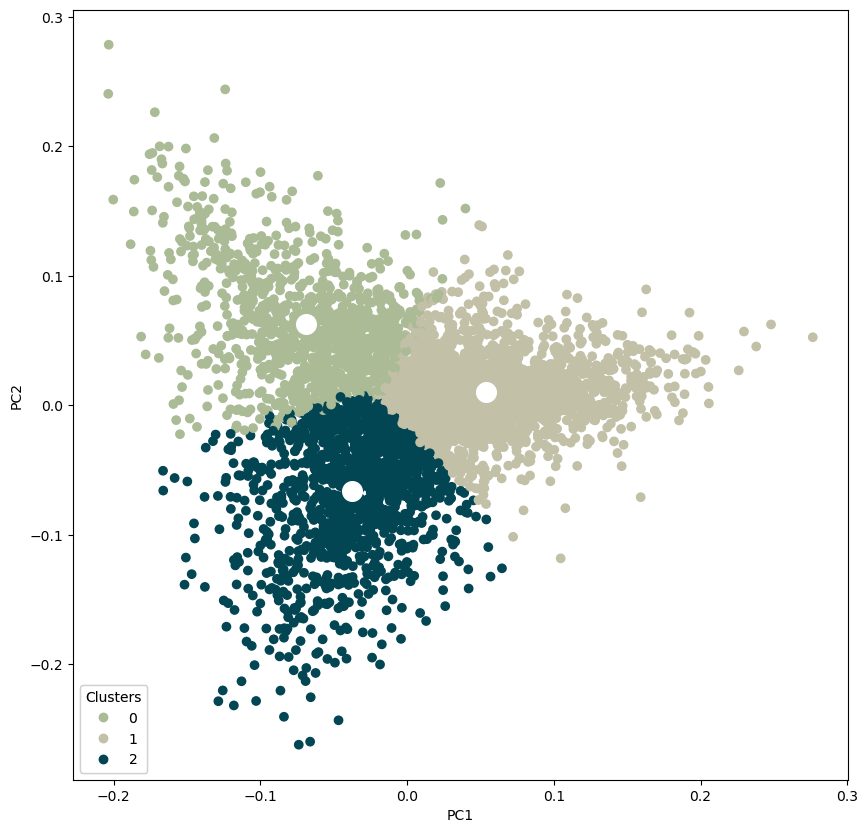

In [89]:
#Reducing the dimensionality with PCA
pca = PCA(n_components=3, random_state=42)
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

kmeans.fit(pca_matrix)

#Define colors
colors = ListedColormap(['#aabb96', '#c2c0a6', '#024553'])

#Plot clusters to a scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(pca_matrix[:,0], pca_matrix[:,1], c=kmeans.labels_, cmap=colors)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

#Plot centroids 
centroid_x = kmeans.cluster_centers_[:,0]
centroid_y = kmeans.cluster_centers_[:,1]
ax.scatter(centroid_x, centroid_y, marker='o', s=200, color='white')

#Add a legend to the plot showing which cluster belongs to which color
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend)

plt.show()

#### K-Means clusters, centroids and query datapoint

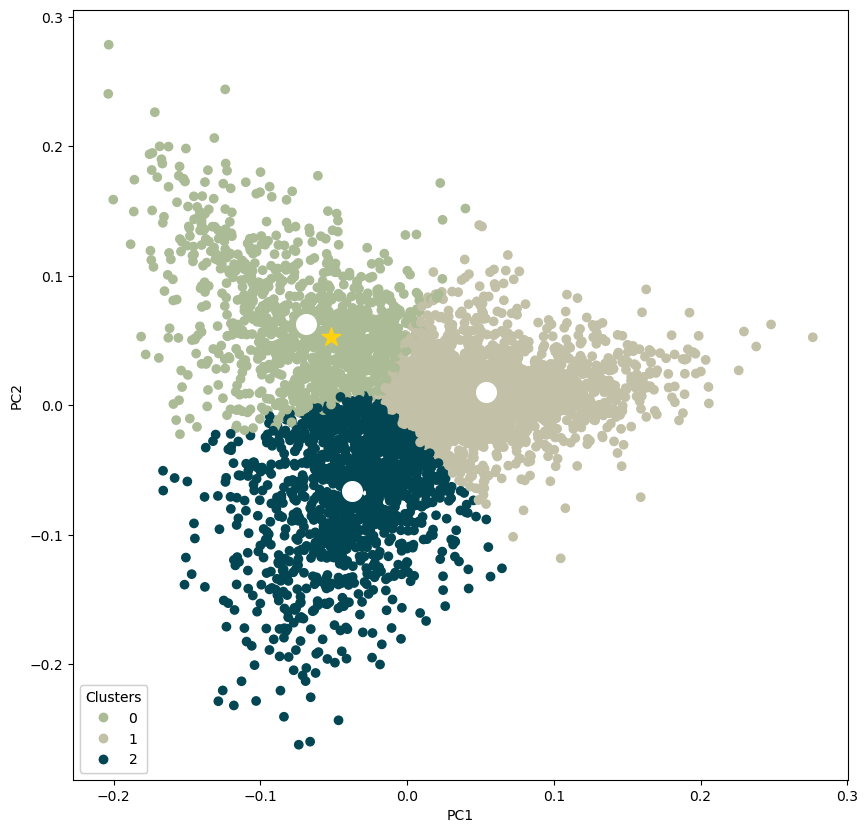

In [90]:
query_pca = pca.transform(tfidf_vectorizer.transform(query_corpus).toarray())

#Extract x and y coordinates of the query data point
x = query_pca[0, 0]
y = query_pca[0, 1]

#Define colors
colors = ListedColormap(['#aabb96', '#c2c0a6', '#024553'])

#Plot clusters to a scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(pca_matrix[:,0], pca_matrix[:,1], c=kmeans.labels_,  cmap=colors)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

#Plot centroids
centroid_x = kmeans.cluster_centers_[:,0]
centroid_y = kmeans.cluster_centers_[:,1]
ax.scatter(centroid_x, centroid_y, marker='o', s=200, color='white')

#Add a legend to the plot showing which cluster belongs to which color
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend)

#Plot query data point
ax.scatter(x, y, marker='*', s=200, color='#FFD10F')

plt.show()